In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
import torch_geometric as T
from torch_geometric.data.data import BaseData, Data
from torch_geometric.utils import from_networkx
from torch_geometric.utils import dense_to_sparse
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

from itertools import product
import random

In [2]:
# Read from csv without second list in daughter columns
training_df = pd.read_csv('train_data.csv')
testing_df = pd.read_csv('test_data.csv')

In [3]:
# Columns including daughter kinematics
train_d_cols = list(training_df[training_df.columns[training_df.columns.str.contains("_Daughters")]])
test_d_cols = list(testing_df[testing_df.columns[testing_df.columns.str.contains("_Daughters")]])

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + ['Jet0_Eta', 'Jet0_PT']
test_f_cols = test_d_cols + ['Jet1_Eta', 'Jet1_PT']

In [4]:
# Duplicate Jet PT and Eta elements as a list the same length as the number of daughters in each row
def duplicate(df, cols, n_col):
    def duplicate_value(row, col, n_col):
        value = row[col]
        if isinstance(value, (float, int)):
            num_daughters = row[n_col]
            return [value] * num_daughters
        return value

    for col in cols:
        df[col] = df.apply(lambda row: duplicate_value(row, col, n_col), axis=1)
    return df

# Converts string into list of floats (already duplicated and dropped second array)
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [5]:
# Duplicate and preprocess daughter columns
df = duplicate(training_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters')
df2 = duplicate(testing_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters')

# Clean up data from str to list of floats
df = convert_to_lists(df, train_d_cols)
df2 = convert_to_lists(df2, test_d_cols)

In [57]:
cut_df = pd.concat([df.head(500), df.iloc[100000:100500]]) 
cut_df2 = pd.concat([df2.head(500), df2.iloc[100000:100500]])

In [48]:
# Gets node features to create x tensor
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

def create_data_object(df, features_cols):
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)
        #train_mask = torch.ones(num_nodes, dtype=torch.bool)
        #test_mask = torch.ones(num_nodes, dtype=torch.bool)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        
    return data_list

In [49]:
train_data = create_data_object(cut_df, train_f_cols)
test_data = create_data_object(cut_df2, test_f_cols)

In [50]:
cut_df.Jet0_Daughters_pT[0]

[226.46542358398438,
 235.54550170898438,
 526.2337646484375,
 318.44940185546875,
 2074.810546875,
 67.70758819580078,
 2634.240966796875,
 2421.313232421875,
 3607.0224609375,
 3046.74365234375,
 256.602294921875]

In [37]:
cut_df.Jet0_Daughters_pT[1]

[226.46542358398438,
 235.54550170898438,
 526.2337646484375,
 318.44940185546875,
 2074.810546875,
 67.70758819580078,
 2634.240966796875,
 2421.313232421875,
 3607.0224609375,
 3046.74365234375,
 256.602294921875]

In [67]:
train_data[500].y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
train_data[1].x

tensor([[ 6.6412e+03,  2.2647e+02,  2.2000e+01,  7.7613e+01,  2.1275e+02,
          6.6373e+03,  4.0713e+00,  1.2210e+00,  0.0000e+00, -1.0000e+02,
          0.0000e+00, -1.0000e+02, -1.0000e+03, -1.0000e+03, -1.0000e+03,
         -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
         -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
          6.9344e+03,  1.0406e+00,  9.2143e-01,  1.5359e+01,  4.3268e+00,
          1.7482e+04],
        [ 1.3513e+04,  2.3555e+02,  2.1100e+02,  2.5076e+01,  2.3421e+02,
          1.3511e+04,  4.7425e+00,  1.4641e+00,  1.0000e+00,  6.3305e-02,
          1.4885e+01,  9.4230e-01,  2.4174e-08,  3.2450e-03,  1.3933e-03,
          9.9259e-01, -1.0000e+03,  1.0706e+00,  2.3392e+02,  8.2260e-01,
         -7.2400e-02,  1.1182e+01,  2.5076e+01,  2.3421e+02,  1.3511e+04,
         -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  4.3268e+00,
          1.7482e+04],
        [ 2.5442e+04,  5.2623e+02,  2.1100e+02,  8.2659e+01,  5.19

In [38]:
# Load data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

/usr/local/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training Model

In [39]:
# Define GNN model

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.sigmoid(x)
        x = self.lin(x)
        return x
            
model = GNN()

In [71]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        print(data.x)
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        #clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return loss.item()

def test():
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            _, pred = out.max(dim=1)
            correct = pred.eq(data.y).sum().item()
            total_correct += correct
            total_samples += len(data.y)

    accuracy = total_correct / total_samples
    return accuracy

for epoch in range(100):
    loss = train()
    acc = test()

    print(f'Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch: 1, Loss: 0.6825, Accuracy: 0.5160
Epoch: 2, Loss: 0.6995, Accuracy: 0.5234
Epoch: 3, Loss: 0.6556, Accuracy: 0.5229
Epoch: 4, Loss: 0.6742, Accuracy: 0.5327
Epoch: 5, Loss: 0.6799, Accuracy: 0.5184
Epoch: 6, Loss: 0.6828, Accuracy: 0.5236
Epoch: 7, Loss: 0.7196, Accuracy: 0.5070
Epoch: 8, Loss: 0.6796, Accuracy: 0.5085
Epoch: 9, Loss: 0.6889, Accuracy: 0.5061
Epoch: 10, Loss: 0.6870, Accuracy: 0.4985
Epoch: 11, Loss: 0.6941, Accuracy: 0.4948
Epoch: 12, Loss: 0.6651, Accuracy: 0.5181
Epoch: 13, Loss: 0.6825, Accuracy: 0.5150
Epoch: 14, Loss: 0.6889, Accuracy: 0.5166
Epoch: 15, Loss: 0.7024, Accuracy: 0.5094
Epoch: 16, Loss: 0.7056, Accuracy: 0.5088
Epoch: 17, Loss: 0.6766, Accuracy: 0.5094
Epoch: 18, Loss: 0.6945, Accuracy: 0.5013
Epoch: 19, Loss: 0.6741, Accuracy: 0.4987
Epoch: 20, Loss: 0.6839, Accuracy: 0.5080
Epoch: 21, Loss: 0.7002, Accuracy: 0.5145
Epoch: 22, Loss: 0.7045, Accuracy: 0.5104
Epoch: 23, Loss: 0.6812, Accuracy: 0.5066
Epoch: 24, Loss: 0.6784, Accuracy: 0.5164
E

# ROC Curve and AUC

In [17]:
y_true = [] # class values (0 or 1)
y_scores = [] # predicted probabilities

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        _, pred = out.max(dim=1)
        y_true.append(data.y.numpy().flatten())
        y_scores.append(out[:, 1].detach().numpy())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [18]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

In [19]:
# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

print(f'Background Rejection: {back_rej}')
print(f'Signal Efficiency: {sig_eff}')
print(f'AUC: {auc}')

Background Rejection: [1.         1.         0.99834983 0.9980198  0.99735974 0.99735974
 0.99669967 0.99669967 0.99636964 0.99636964 0.99636964 0.9960396
 0.9960396  0.99570957 0.9950495  0.99339934 0.99141914 0.99141914
 0.99009901 0.98943894 0.98943894 0.98844884 0.98811881 0.98712871
 0.98679868 0.98613861 0.98613861 0.98547855 0.98481848 0.98448845
 0.98382838 0.98382838 0.98349835 0.98349835 0.98316832 0.98316832
 0.98283828 0.98250825 0.98250825 0.98184818 0.98184818 0.98118812
 0.98118812 0.98085809 0.98085809 0.97986799 0.97788779 0.97755776
 0.97755776 0.97656766 0.97590759 0.97557756 0.97557756 0.97557756
 0.97557756 0.97557756 0.97557756 0.97524752 0.97524752 0.97458746
 0.97458746 0.97392739 0.97392739 0.97359736 0.97359736 0.97293729
 0.97293729 0.97293729 0.97227723 0.97227723 0.95973597 0.94455446
 0.94389439 0.94323432 0.94191419 0.9349835  0.93234323 0.9320132
 0.9310231  0.93069307 0.930033   0.930033   0.92970297 0.92970297
 0.92970297 0.92838284 0.92772277 0.927722

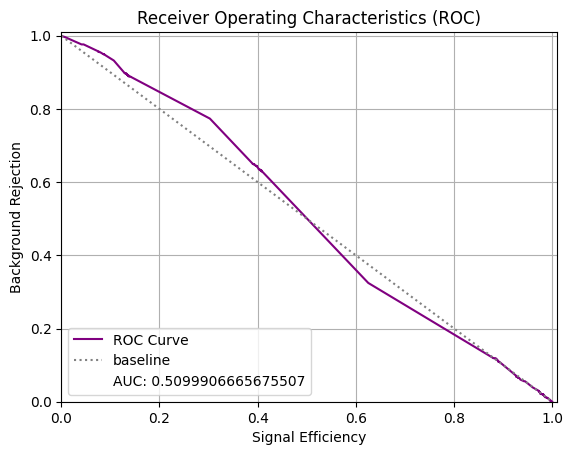

In [20]:
# Plot ROC Curve and show AUC
plt.plot(back_rej, sig_eff, label='ROC Curve', color='purple')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.plot([], [], ' ', label=f'AUC: {auc}')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()